# Pressupostos Regressão Logistica

Quando os pressupostos de uma regressão logistica não são respeitados, problemas como variáveis com estimativas enviesadas ou com erros-padrão muito elevados, podem levar a inferências estatísticas inválidas para o modelo. 

Para este projeto vamos trabalhar com 6 pressupostos que devem ser respeitados, para que no final tenhamos um modelo que nos gere conclusões estatísticamente confiáveis. Os pressupostos são:

- Pressuposto 1 - Variável dependente ser categórica.


- Pressuposto 2 - Linearidade do Logit: deve haver uma relação linear entre o logit da variável dependente e as variáveis independentes.


- Pressuposto 3 - Não haver forte influência de outliers no modelo. 


- Pressuposto 4 - Ausência de multicolinearidade entre as variáveis independentes.


- Pressuposto 5 - Independência das observações (resíduos).


- Pressuposto 6 - Dimensão da amostra suficientemente grande. 

## 1. Carregando os Dados e Explorando o Dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
import statsmodels.api as sm 
import statsmodels.formula.api as smf
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.set_option('display.max_columns', 40)

import warnings
warnings.filterwarnings("ignore")


In [2]:
df = pd.read_csv('data/processed/customer_booking_processed.csv')

In [3]:
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,time_of_day,arrival_hour,same_day_arrival,weekend_trip,length_of_stay_months,length_of_stay_years,total_benefits,lead_per_passenger,continent_booking_origin,solo_flight,Origin_City,Destiny_City
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0,morning,12.52,yes,yes,0.633333,0.052778,1,131.0,oceania,no,AKL,DEL
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0,night,8.52,yes,yes,0.666667,0.055556,0,112.0,oceania,yes,AKL,DEL
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0,afternoon,22.52,yes,no,0.733333,0.061111,2,121.5,asia,no,AKL,DEL
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0,night,9.52,yes,yes,1.033333,0.086111,1,96.0,oceania,yes,AKL,DEL
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0,afternoon,20.52,yes,no,0.733333,0.061111,2,34.0,asia,no,AKL,DEL


In [4]:
df.shape

(49281, 26)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49281 entries, 0 to 49280
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   num_passengers            49281 non-null  int64  
 1   sales_channel             49281 non-null  object 
 2   trip_type                 49281 non-null  object 
 3   purchase_lead             49281 non-null  int64  
 4   length_of_stay            49281 non-null  int64  
 5   flight_hour               49281 non-null  int64  
 6   flight_day                49281 non-null  object 
 7   route                     49281 non-null  object 
 8   booking_origin            49281 non-null  object 
 9   wants_extra_baggage       49281 non-null  int64  
 10  wants_preferred_seat      49281 non-null  int64  
 11  wants_in_flight_meals     49281 non-null  int64  
 12  flight_duration           49281 non-null  float64
 13  booking_complete          49281 non-null  int64  
 14  time_o

In [6]:
df.isnull().sum()

num_passengers              0
sales_channel               0
trip_type                   0
purchase_lead               0
length_of_stay              0
flight_hour                 0
flight_day                  0
route                       0
booking_origin              0
wants_extra_baggage         0
wants_preferred_seat        0
wants_in_flight_meals       0
flight_duration             0
booking_complete            0
time_of_day                 0
arrival_hour                0
same_day_arrival            0
weekend_trip                0
length_of_stay_months       0
length_of_stay_years        0
total_benefits              0
lead_per_passenger          0
continent_booking_origin    0
solo_flight                 0
Origin_City                 0
Destiny_City                0
dtype: int64

## 2. Pré-Processamento

Como observmamos, não temos valores missing no dataset. 

O pré-processamento será focado na transformação das variáveis categóricas. Aqui a função <i>get_dummies</i> do pandas será muito utilizado, julgo ser a melhor forma de fazer transformações de variáveis categóricas quando se tratam de dados não ordenados, principalmente por seu parâmetro <i>drop_first</i>, que auxilia na diminuição da colinearidade.

In [7]:
# Criando variáveis dummy
dummy_sales_chanel = pd.get_dummies(df['sales_channel'], drop_first=True).rename(columns=lambda x: 'sale_channel_' + str(x))
dummy_trip_type = pd.get_dummies(df['trip_type'], drop_first=True).rename(columns=lambda x: 'trip_type_' + str(x))
dummy_continent_booking = pd.get_dummies(df['continent_booking_origin'], drop_first=True).rename(columns=lambda x: 'continent_booking_' + str(x))
dummy_time_day = pd.get_dummies(df['time_of_day'], drop_first=True).rename(columns=lambda x: 'time_of_dat_' + str(x))
dummy_same_day = pd.get_dummies(df['same_day_arrival'], drop_first=True).rename(columns=lambda x: 'same_day_arrival_' + str(x))
dummy_weekend_trip = pd.get_dummies(df['weekend_trip'], drop_first=True).rename(columns=lambda x: 'weekend_trip_' + str(x))
dummy_solo_flight = pd.get_dummies(df['solo_flight'], drop_first=True).rename(columns=lambda x: 'solo_flight' + str(x))

# Concatenando o dataset
df = pd.concat([df, dummy_sales_chanel, dummy_trip_type, dummy_continent_booking, dummy_time_day, dummy_same_day, dummy_weekend_trip, dummy_solo_flight], axis=1)

# Excluindo variaveis orignais
cols_exclude = ['sales_channel', 'trip_type', 'continent_booking_origin', 'time_of_day', 'same_day_arrival', 'weekend_trip', 'solo_flight']
df = df.drop(cols_exclude, axis=1)

Algumas outras variáveis serão excluídas do processo de modelagem.

In [8]:
cols = ['flight_day', 'route', 'booking_origin', 'Origin_City', 'Destiny_City']

df = df.drop(cols, axis=1)

## 3. Modelo

In [9]:
# Definindo as variáveis dependente e independentes
y = df['booking_complete']
X = df.drop('booking_complete', axis=1)

In [10]:
formula = 'booking_complete ~ ' + ' + '.join(X.columns)
print(formula)

booking_complete ~ num_passengers + purchase_lead + length_of_stay + flight_hour + wants_extra_baggage + wants_preferred_seat + wants_in_flight_meals + flight_duration + arrival_hour + length_of_stay_months + length_of_stay_years + total_benefits + lead_per_passenger + sale_channel_Mobile + trip_type_OneWay + trip_type_RoundTrip + continent_booking_america + continent_booking_asia + continent_booking_europe + continent_booking_oceania + continent_booking_other + time_of_dat_morning + time_of_dat_night + same_day_arrival_yes + weekend_trip_yes + solo_flightyes


In [11]:
modelo = smf.ols(formula=formula, data=df)

res = modelo.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:       booking_complete   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     153.5
Date:                Wed, 18 Oct 2023   Prob (F-statistic):               0.00
Time:                        17:37:14   Log-Likelihood:                -17539.
No. Observations:               49281   AIC:                         3.512e+04
Df Residuals:                   49258   BIC:                         3.533e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

## 3. Pressupostos

### 3.1 - Pressuposto 1 - Variável dependente ser categórica

A regressão logistica geralmente funciona como um classificador, desta forma, o tipo de regressão utilizado (binário, multinomial ou ordinal) deve corresponder a variável dependente no conjunto de dados. 

Por padrão, a regressão logística pressupõe que a variável dependente seja binária, ou seja, o número de resultados possíveis não seja maior que dois (sim/não, por exemplo).

Se a variável dependente exceder duas possibilidades de resultados possíveis, deverá ser usada a regressão logística multinomial ou ordinal. 

In [12]:
df['booking_complete'].value_counts()

0    41890
1     7391
Name: booking_complete, dtype: int64

In [13]:
df['booking_complete'].nunique()

2

Como podemos observar através das funções velue_counts e nunique, nossa variável dependente é binária (0 e 1), por isso estamos falando de uma regressão logística binária. 

Sendo a variável dependente categórica, está sendo respeitado o primeito pressuposto do modelo. 

### 3.2 - Pressuposto 2 - Linearidade das variáveis indepdentes e das probabilidades logarítmicas

Deve haver uma relação linear entre o logit da variável dependente e as variáveis independentes contínuas. 

O logit pode ser definido como o logarítmo da razão de chances de um resultado positivo (o cliente reservar sua passagem, por exemplo).

logit(p) = log(p/1-p)

p = probabilidade de um resultado positivo. 

Esta checagem pode ser feita de duas maneiras distintas:

- Através de gráficos de dispersão;
- Através do teste de Box-Tidwell

In [14]:
logit_results = GLM(y, X, family=families.Binomial()).fit()
predicted = logit_results.predict(X)

log_odds = np.log(predicted / (1 - predicted))

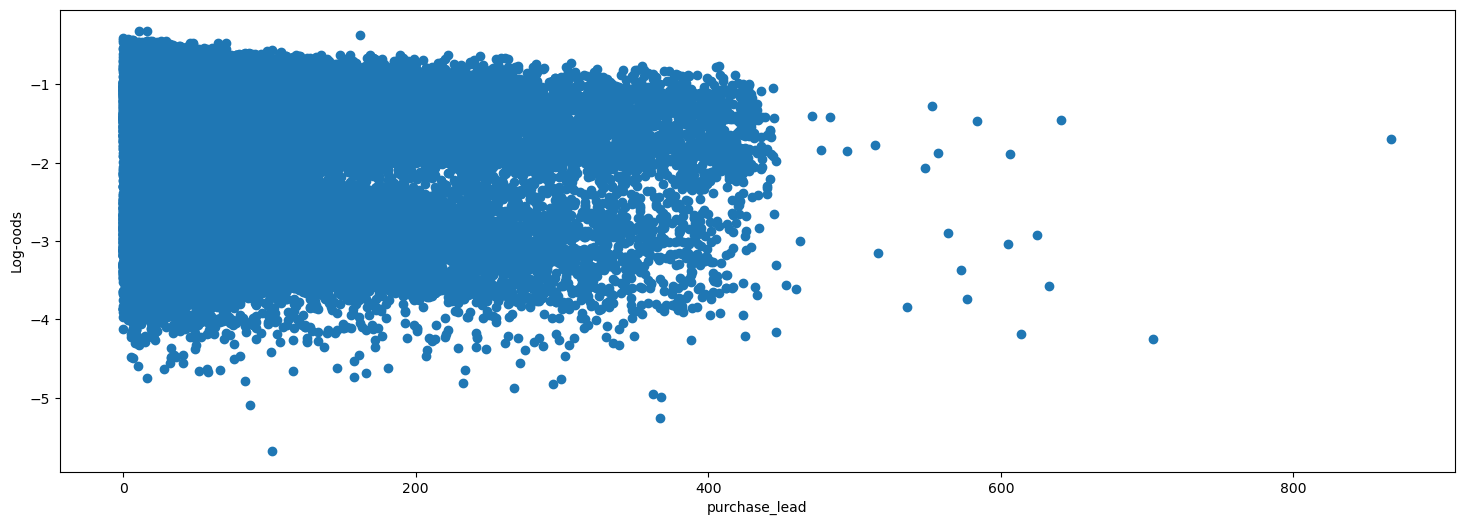

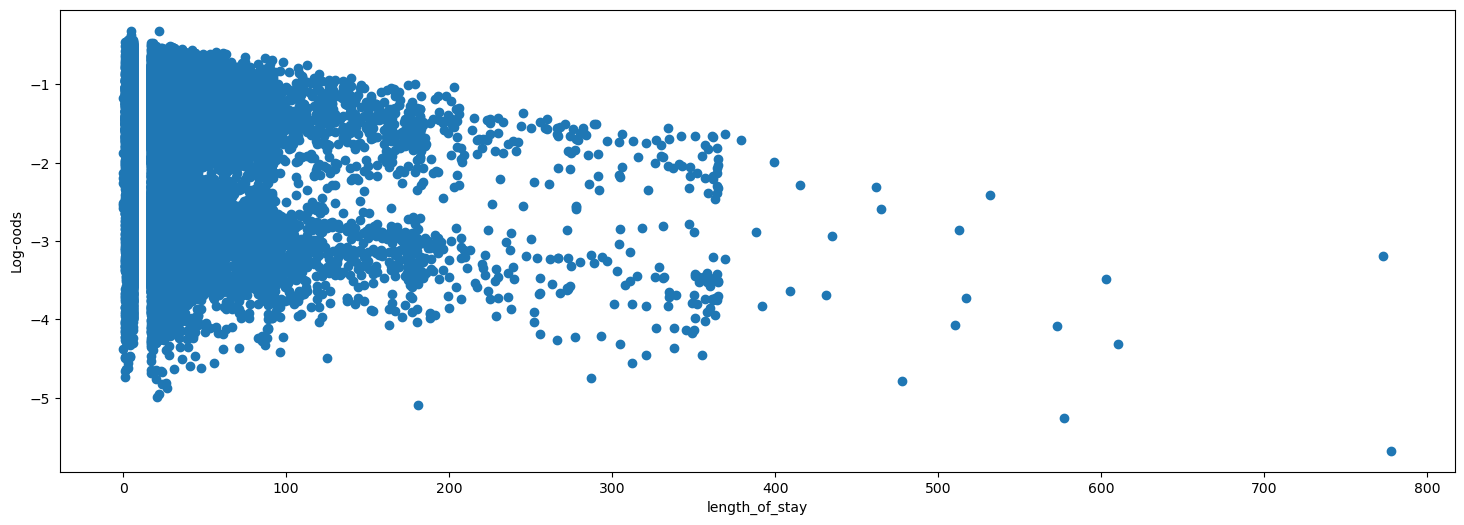

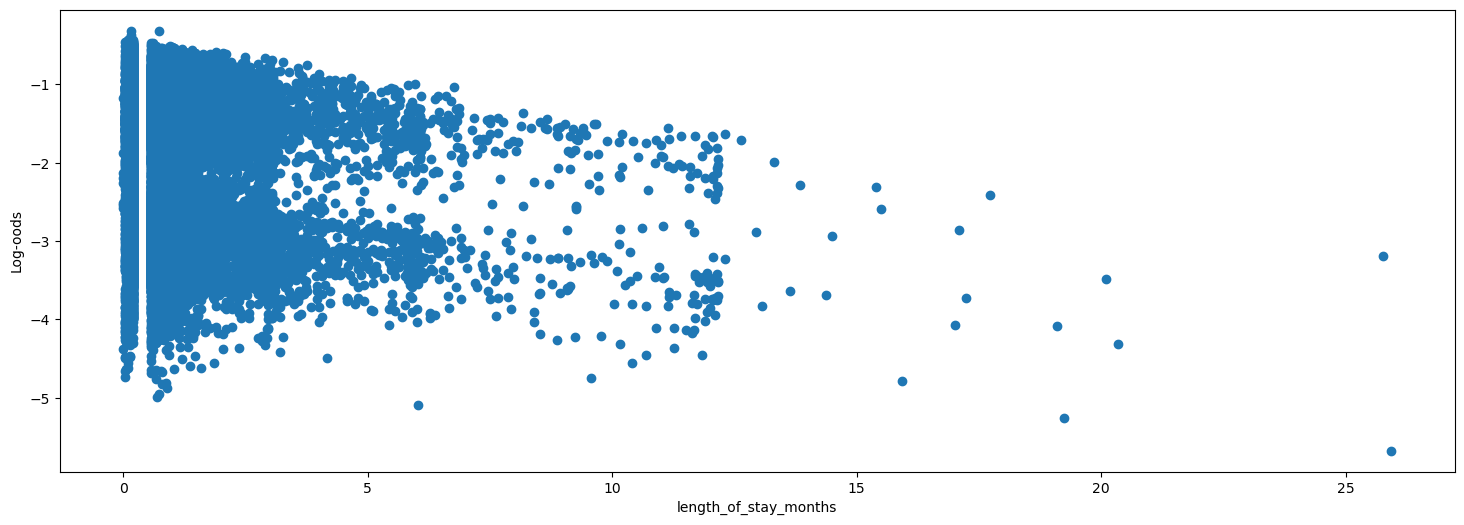

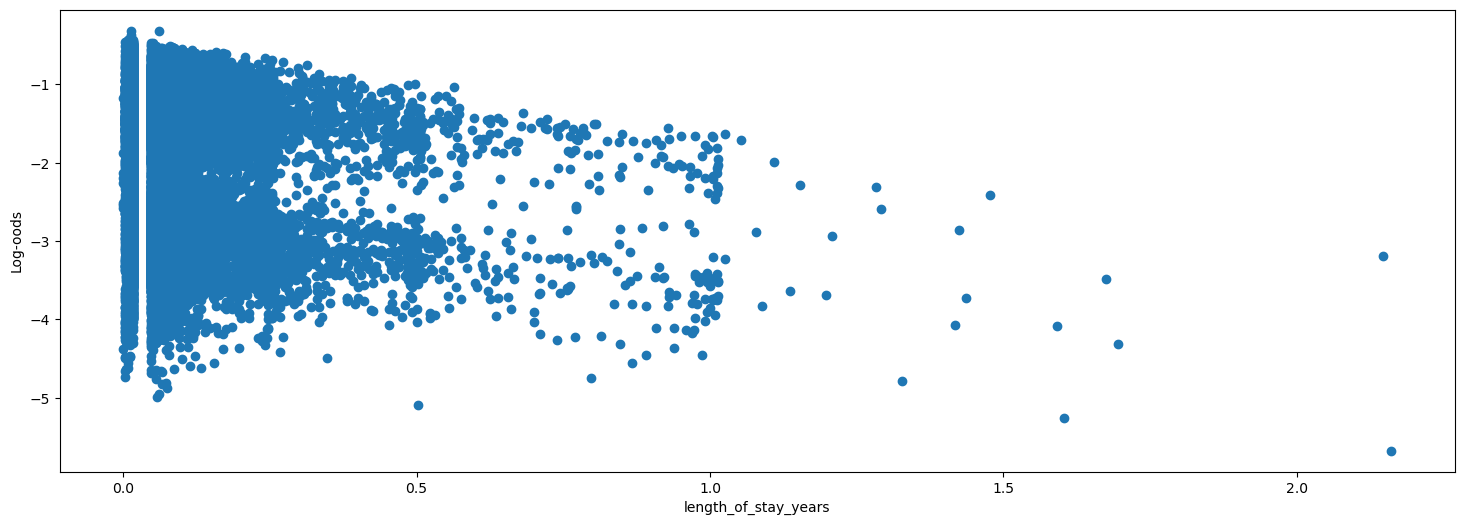

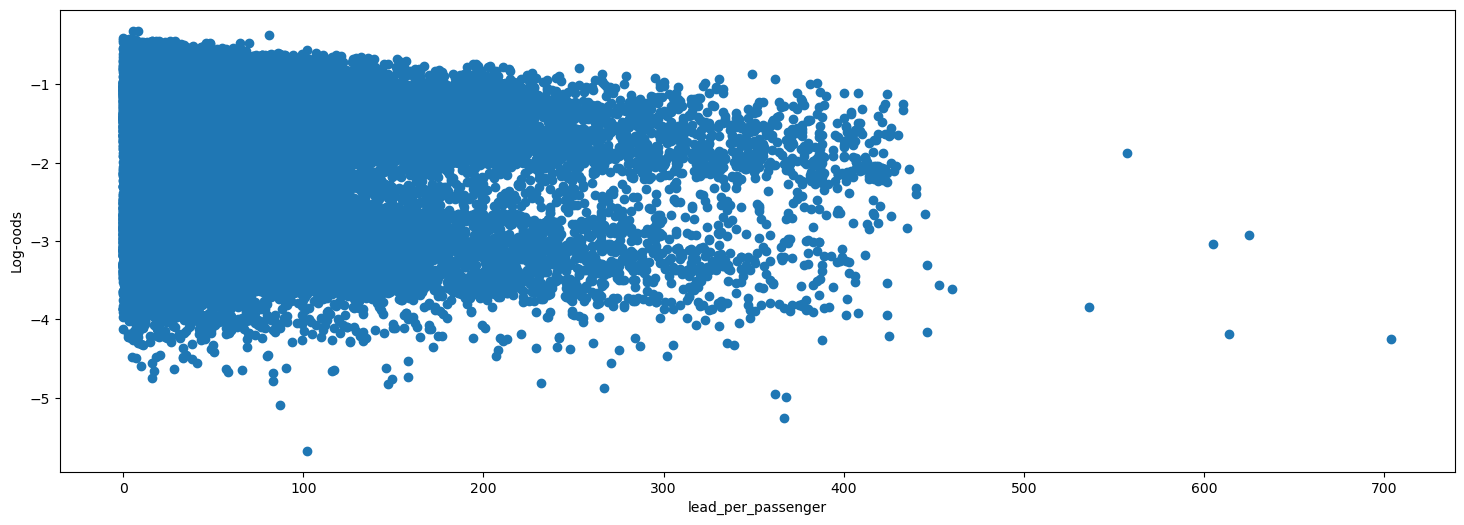

In [15]:
continuous_cols = ['purchase_lead', 'length_of_stay', 'length_of_stay_months', 'length_of_stay_years', 'lead_per_passenger']

for col in continuous_cols:
    plt.figure(figsize=(18,6))
    plt.scatter(x = df[col].values, y = log_odds)
    plt.xlabel(col)
    plt.ylabel('Log-oods')
    plt.show()

É possível perceber que todas as variáveis independentes contínuas possuem uma relação linear com o logit da variável dependente. 

Caso a análise através dos gráficos não seja conclusive, é possível aplicar o teste Box-Twidell para confirmar a existência da linearidade ou não entre as variáveis.

### 3.3 - Pressuposto 3 - Não haver forte influência de outliers

A regressão logística parte do princípio que não há pontos de dados discrepantes que possuam grande influência, pois eles distorcem o resultado e a precisão do modelo. 

É importante mencionar que nem todos os outliers são influentes, então o modelo pode conter valores outliers, mas não deve conter valores outliers e influentes. 

Analisando valores outliers:

- Pode ser usado os resíduos padronizados para determinar se um ponto de dados é outlier ou não. 

- Dados com valores residuais padronizados absolutos superiores a 3 representam possíveis outliers.

Analisando influência dos outliers:

- Para medir a influência de um outlier pode ser usado a distância de Cook, que é calculada com base no resíduo. 

- Aqui vamos utilizar um limite de 4/N (onde N = número de observações), o que significa que observações com distância de Cook > 4/N são consideradas influentes.

- Temos acesso a esses valores a partir da função <i>get_influence</i> do statsmodels.



In [16]:
logit_model = GLM(y, X, family=families.Binomial())
logit_res = logit_model.fit()
print(logit_res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:       booking_complete   No. Observations:                49281
Model:                            GLM   Df Residuals:                    49259
Model Family:                Binomial   Df Model:                           21
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -19066.
Date:                Wed, 18 Oct 2023   Deviance:                       38133.
Time:                        17:37:16   Pearson chi2:                 4.98e+04
No. Iterations:                     6   Pseudo R-squ. (CS):            0.06906
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
num_passengers        

In [17]:
# valores de influência
influence_values = logit_res.get_influence()

# quadro resumo dos valores de influência
df_influences = influence_values.summary_frame()

# filtrando apenas a distancia de cook
df_filter = df_influences.loc[:,['cooks_d']]

# add ao df valores residuais padronizados
df_filter['std_resid'] = stats.zscore(logit_res.resid_pearson)
df_filter['std_resid'] = df_filter.loc[:,'std_resid'].apply(lambda x: np.abs(x))

# Ordenando pela distancia de cook
df_filter.sort_values("cooks_d", ascending=False)
df_filter.head()


,cooks_d,std_resid
0,4.469405e-07,0.236822
1,1.600413e-07,0.191540
2,8.136403e-06,0.604985
3,2.341531e-07,0.206115
4,4.993988e-06,0.603274


Limite para distância de cook = 8.116718410746535e-05


<Figure size 2000x1000 with 0 Axes>

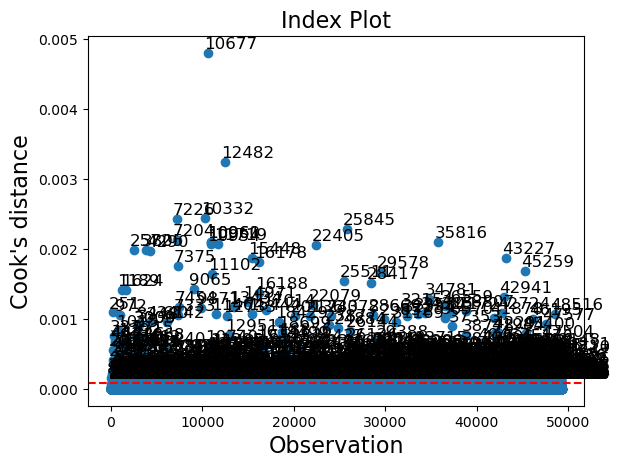

In [44]:
# definindo o limite da distancia de cook
cook_limit = 4 / len(df)
print(f"Limite para distância de cook = {cook_limit}")

# pltando as distâncias de cook
plt.figure(figsize=(20,10))
fig = influence_values.plot_index(y_var="cooks", threshold=cook_limit)
plt.axhline(y = cook_limit, ls="--", color='red')
plt.show()

In [19]:
# numero de observações que excedem o limite de distância de cook
outliers = df_filter[df_filter['cooks_d'] > cook_limit]
perc_outliers = round(100*(len(outliers) / len(df)),1)
print(f'Porcentagem de dados são altamente influentes = {perc_outliers}%')

Porcentagem de dados são altamente influentes = 5.1%


Apenas aproximadamente 5% dos dados são outliers com influência sobre o modelo, o que pode ser considerado baixo. O problema surge quando há um número significativo de outliers influentes. 

### 3.4 - Pressuposto 4 - Ausência de multicolinearidade entre as variáveis independentes.

A multicolinearidade ocorre quando os dados contêm variáveis independentes altamente correlacionadas. 

Variáveis independentes muito correlacionadas reduzem a precisão dos coeficientes estimados, o que enfraquece o poder estatístico do modelo de regressão logística.

Utilizaremos duas maneiras diferentes para verificar a multicolinearidade: a matriz de correlação e o VIF.

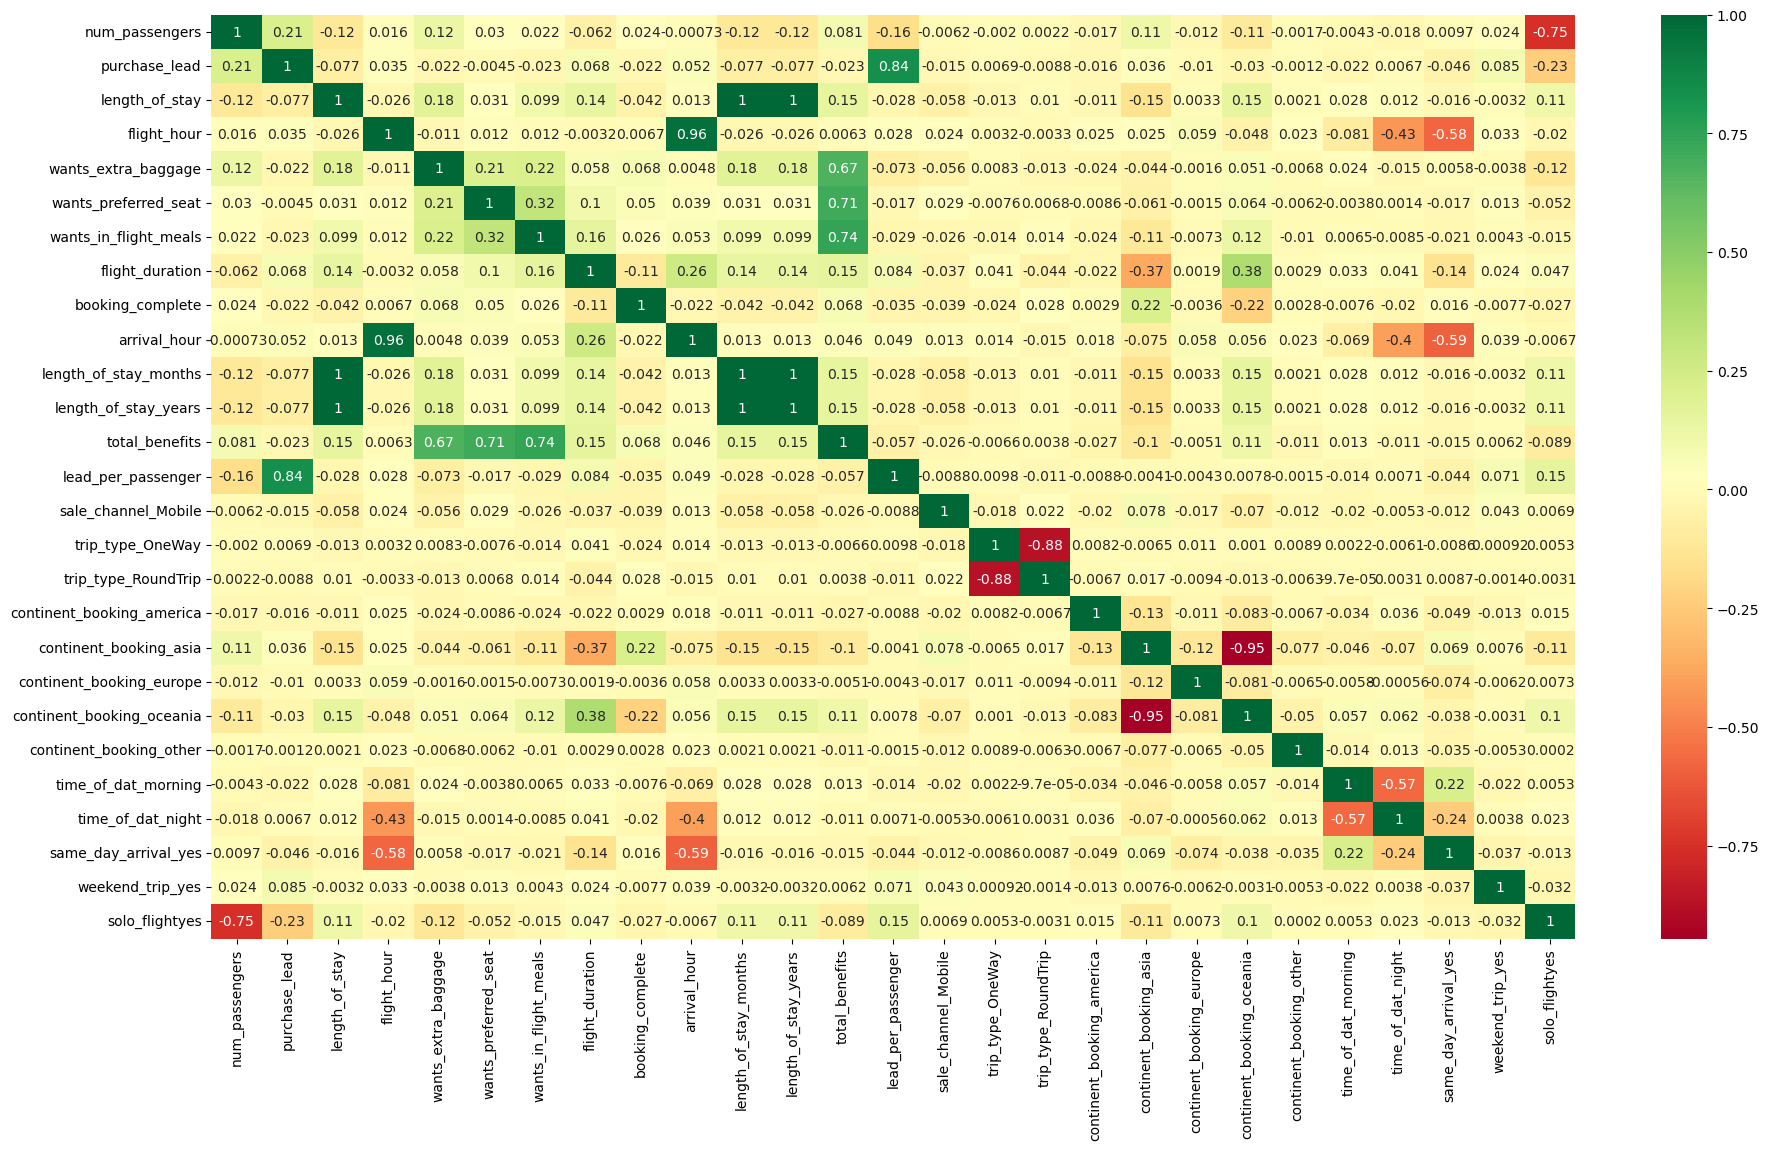

In [20]:
corr = df.corr()
plt.subplots(figsize=(22, 12))
sns.heatmap(corr, annot=True, cmap="RdYlGn")
plt.show()

É possível perceber através da matriz de correlação que existem variáveis com forte colinearidade, mas devivo ao elevado número de variáveis, visualmente a matriz não está tão nítido, por isso também utilizaremos o VIF.

Para o VIF, utilizaremos o valor máximo de 5, ou seja, valores de VIF acima de 5 serão considerados variáveis com colinearidade, e serão excluídas do modelo. 

In [21]:
# Calculando o VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Variaveis"] = X.columns
vif

,VIF,Variaveis
0,8.917430,num_passengers
1,13.030265,purchase_lead
2,inf,length_of_stay
3,inf,flight_hour
4,inf,wants_extra_baggage
5,inf,wants_preferred_seat
6,inf,wants_in_flight_meals
7,inf,flight_duration
8,inf,arrival_hour
9,inf,length_of_stay_months


Quando o retorno do vif é "inf", significa uma correlação perfeita. Não podemos ter valores "inf" dentro do modelo.

In [22]:
X_vif1 = df.drop('flight_hour', axis=1)

In [23]:
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X_vif1.values, i) for i in range(X_vif1.shape[1])]
vif["Variaveis"] = X_vif1.columns
vif

,VIF,Variaveis
0,8.918685,num_passengers
1,13.030336,purchase_lead
2,inf,length_of_stay
3,inf,wants_extra_baggage
4,inf,wants_preferred_seat
5,inf,wants_in_flight_meals
6,35.795396,flight_duration
7,1.257062,booking_complete
8,44.160769,arrival_hour
9,inf,length_of_stay_months


In [24]:
X_vif2 = X_vif1.drop(['wants_extra_baggage', 'length_of_stay_years', 'length_of_stay_months'], axis=1)

In [25]:
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X_vif2.values, i) for i in range(X_vif2.shape[1])]
vif["Variaveis"] = X_vif2.columns
vif

,VIF,Variaveis
0,8.918685,num_passengers
1,13.030336,purchase_lead
2,1.596040,length_of_stay
3,3.609571,wants_preferred_seat
4,4.828750,wants_in_flight_meals
5,35.795396,flight_duration
6,1.257062,booking_complete
7,44.160769,arrival_hour
8,15.086076,total_benefits
9,11.908361,lead_per_passenger


In [26]:
X_vif3 = X_vif2.drop('trip_type_RoundTrip', axis=1)

In [27]:
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X_vif3.values, i) for i in range(X_vif3.shape[1])]
vif["Variaveis"] = X_vif3.columns
vif

,VIF,Variaveis
0,8.884850,num_passengers
1,13.030331,purchase_lead
2,1.595856,length_of_stay
3,3.609499,wants_preferred_seat
4,4.828748,wants_in_flight_meals
5,35.791176,flight_duration
6,1.256791,booking_complete
7,42.547572,arrival_hour
8,15.084295,total_benefits
9,11.908361,lead_per_passenger


In [28]:
X_vif4 = X_vif3.drop('continent_booking_asia', axis=1)

In [29]:
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X_vif4.values, i) for i in range(X_vif4.shape[1])]
vif["Variaveis"] = X_vif4.columns
vif

,VIF,Variaveis
0,8.378584,num_passengers
1,13.025562,purchase_lead
2,1.595773,length_of_stay
3,3.597904,wants_preferred_seat
4,4.810287,wants_in_flight_meals
5,35.773410,flight_duration
6,1.252965,booking_complete
7,16.194836,arrival_hour
8,14.990481,total_benefits
9,11.908297,lead_per_passenger


In [30]:
X_vif5 = X_vif4.drop('flight_duration', axis=1)

In [31]:
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X_vif5.values, i) for i in range(X_vif5.shape[1])]
vif["Variaveis"] = X_vif5.columns
vif

,VIF,Variaveis
0,8.376142,num_passengers
1,13.011615,purchase_lead
2,1.584920,length_of_stay
3,3.596615,wants_preferred_seat
4,4.798892,wants_in_flight_meals
5,1.252265,booking_complete
6,8.101363,arrival_hour
7,14.988033,total_benefits
8,11.908274,lead_per_passenger
9,1.142555,sale_channel_Mobile


In [32]:
X_vif6 = X_vif5.drop('total_benefits', axis=1)

In [33]:
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X_vif6.values, i) for i in range(X_vif6.shape[1])]
vif["Variaveis"] = X_vif6.columns
vif

,VIF,Variaveis
0,8.327114,num_passengers
1,13.010144,purchase_lead
2,1.534891,length_of_stay
3,1.592048,wants_preferred_seat
4,1.982670,wants_in_flight_meals
5,1.246073,booking_complete
6,7.910674,arrival_hour
7,11.908139,lead_per_passenger
8,1.140709,sale_channel_Mobile
9,1.009829,trip_type_OneWay


In [34]:
X_vif7 = X_vif6.drop('purchase_lead', axis=1)

In [35]:
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X_vif7.values, i) for i in range(X_vif7.shape[1])]
vif["Variaveis"] = X_vif7.columns
vif

,VIF,Variaveis
0,7.365921,num_passengers
1,1.534741,length_of_stay
2,1.591701,wants_preferred_seat
3,1.982572,wants_in_flight_meals
4,1.246069,booking_complete
5,7.880786,arrival_hour
6,1.848675,lead_per_passenger
7,1.140595,sale_channel_Mobile
8,1.009826,trip_type_OneWay
9,1.025295,continent_booking_america


In [36]:
X_vif8 = X_vif7.drop('same_day_arrival_yes', axis=1)

In [37]:
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X_vif8.values, i) for i in range(X_vif8.shape[1])]
vif["Variaveis"] = X_vif8.columns
vif

,VIF,Variaveis
0,5.044295,num_passengers
1,1.527063,length_of_stay
2,1.586198,wants_preferred_seat
3,1.975856,wants_in_flight_meals
4,1.235881,booking_complete
5,7.853128,arrival_hour
6,1.824416,lead_per_passenger
7,1.137068,sale_channel_Mobile
8,1.009762,trip_type_OneWay
9,1.025289,continent_booking_america


Nesta última versão todos os valores se encontram abaixo de 5, ou muito pŕoximos. Isso significa dizer que não temos uma colinearidade entre as variáveis independentes que possa impactar no modelo. 

In [38]:
df_copy = X_vif8

### 3.5 - Pressuposto 5 - Independência das observações (resíduos)


As observações devem ser independentes umas das outras, ou seja, uma observação não pode ter influência da anterior e nem influenciar a próxima.

Essa suposição de independência é automaticamente atendida no nosso conjunto de dado, pois os dados consistem em registros individuais de clientes da companhia áerea.

Em De qualquer forma, podemos criar o gráfico Residual Series (Série residual), no qual plotamos os resíduos de desvio do modelo logit em relação aos números de índice das observações.

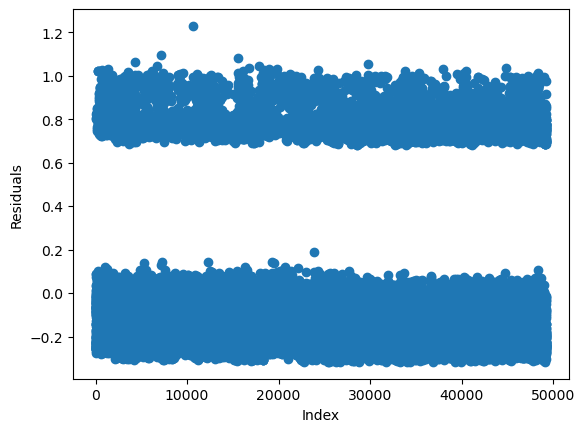

In [39]:
# Analisando a autocorrelação dos resíduos
autocorrelacao = res.resid.reset_index().rename(columns={0: "resid"})
plt.scatter(autocorrelacao["index"], autocorrelacao["resid"])
plt.xlabel("Index")
plt.ylabel("Residuals")

plt.show()

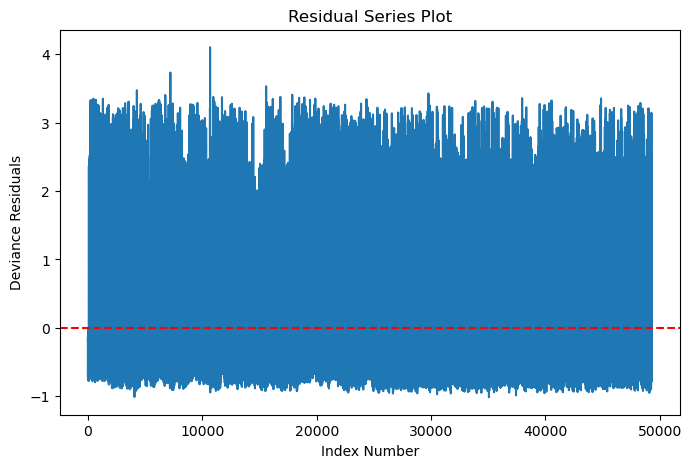

In [40]:
logit_res = GLM(y, X, family=families.Binomial()).fit()

# plot
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, title="Residual Series Plot",
                     xlabel="Index Number", 
                     ylabel="Deviance Residuals")

# gerando gráfico de série residual
ax.plot(df.index.tolist(), 
        stats.zscore(logit_res.resid_deviance))
plt.axhline(y = 0, ls="--", color='red')

### 3.6 - Pressuposto 6 - Dimensão da amostra suficientemente grande

Normalmente se define que um conjuneto de dados deve possuir mais que 500 observações. Como estamos trabalhando com um conjunto de dados de quase 50.000 observações, esse pressuposto é atendido com facilidade.

## 4. Modelo Final

In [41]:
df_copy['booking_complete'] = df['booking_complete']

X = df_copy.drop('booking_complete', axis=1)
y = df_copy['booking_complete']


# Printando modelo final
logit_model = GLM(y, X, family=families.Binomial())
logit_results = logit_model.fit()
print(logit_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:       booking_complete   No. Observations:                49281
Model:                            GLM   Df Residuals:                    49265
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -19254.
Date:                Wed, 18 Oct 2023   Deviance:                       38509.
Time:                        17:37:39   Pearson chi2:                 5.03e+04
No. Iterations:                     6   Pseudo R-squ. (CS):            0.06193
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
num_passengers        

Agora que nosso modelo passou por todos os pressupostos sem cometer qualquer tipo de violação, podemos interpretá-lo levando em consideração a significância estatística. Desta forma, vamos excluir as variáveis que possuem um p-valor > 0.001.

In [42]:
df_copy = df_copy.drop(['continent_booking_america', 'continent_booking_other', 'weekend_trip_yes'], axis=1)

X = df_copy.drop('booking_complete', axis=1)
y = df_copy['booking_complete']

# Printando modelo final
logit_model = GLM(y, X, family=families.Binomial())
logit_results = logit_model.fit()
print(logit_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:       booking_complete   No. Observations:                49281
Model:                            GLM   Df Residuals:                    49268
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -19261.
Date:                Wed, 18 Oct 2023   Deviance:                       38522.
Time:                        17:37:39   Pearson chi2:                 5.03e+04
No. Iterations:                     6   Pseudo R-squ. (CS):            0.06167
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
num_passengers        

## 5. Conclusões e Insights

- Apenas as variáveis <i>wants_preferred_seat</i> e <i>wants_in_flight_meals</i> possuem impacto positivo na decisão do cliente de efetivar a sua reserva de passagem. 


- A variável que mais possui impacto no modelo é <i>continent_booking_oceania</i>, ou seja, clientes da Oceania possuem maior chance de não efetivar a reserva de suas passagens. 


- A segunda variável que mais possui impacto no poder de decisão do cliente é <i>trip_type_OneWay</i>, ou seja, clientes que tem o objetivo de comprar apenas um trecho, tendem mais a não efetivar a reserva da passagem.


- A variável que menos possui impacto é a <i>lead_per_passenger</i>, isso quer dizer que o tempo existente entre o dia da compra da passagem e o dia da viagem, não possui grande influência na decisão do cliente de viajar ou não.